In [202]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [203]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [204]:
for X, y in trainloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 3, 32, 32])
Shape of y:  torch.Size([256]) torch.int64


In [205]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder definition
        self.conv1 = nn.Conv2d(3, 6, 5)    # 32 x 32 -> 28 x 28
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)     # 28 x 28 -> 14 x 14
        self.conv2 = nn.Conv2d(6, 16, 5)   # 14 x 14 -> 10 x 10 --pool---> 5 x 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Decoder definition
        self.fc4 = nn.Linear(10, 84)
        self.fc5 = nn.Linear(84, 120)
        self.fc6 = nn.Linear(120, 16 * 5 * 5)
        self.deconv1 = nn.ConvTranspose2d(16, 6, 5)
        self.deconv2 = nn.ConvTranspose2d(6, 3, 5)
        self.unpool = nn.MaxUnpool2d(2, 2)
    
    def forward(self, x, path = 'all'):
        #Encoder
        x, indices1 = self.pool(F.relu(self.conv1(x)))   # 32 x 32 -> 28 x 28 -> 14 x 14
        x, indices2 = self.pool(F.relu(self.conv2(x)))   # 14 x 14 -> 10 x 10 -> 5 x 5
        #print(indices1.shape, indices2.shape)
        x = x.view(-1, 16 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Decoder
        x = self.fc4(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        # if we want the bottleNeck features, just return the parameters when it's in fc6 layer
        if path == 'bottleNeck':
            return x
        
        x = x.view(-1, 16, 5, 5)   # None x 5 x 5 x 16
        x = F.relu(self.deconv1(self.unpool(x, indices2)))
        x = F.relu(self.deconv2(self.unpool(x, indices1)))
        
        x = torch.tanh(x)
        
        return x


autoEncoder = AutoEncoder()

In [206]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(autoEncoder.parameters(), lr = 1e-3)

autoEncoder.to(device)
autoEncoder =  nn.DataParallel(autoEncoder)  #use two GPUs
print(device)

cuda:0


In [207]:
epoch_num = 100

import time

for epoch in range(epoch_num):  # loop over the dataset multiple times
    t0  = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoEncoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print('[epoch %d] loss: %f time: %.3f' %
                (epoch + 1, running_loss / 2000, time.time() - t0))
    running_loss = 0.0

print('Finished Training')

[epoch 1] loss: 0.023748 time: 4.210
[epoch 2] loss: 0.020976 time: 4.368
[epoch 3] loss: 0.019914 time: 4.280
[epoch 4] loss: 0.019668 time: 4.274
[epoch 5] loss: 0.019557 time: 4.381
[epoch 6] loss: 0.019485 time: 4.501
[epoch 7] loss: 0.019437 time: 4.322
[epoch 8] loss: 0.019397 time: 4.213
[epoch 9] loss: 0.019377 time: 4.269
[epoch 10] loss: 0.019354 time: 4.320
[epoch 11] loss: 0.019338 time: 4.256
[epoch 12] loss: 0.019315 time: 4.288
[epoch 13] loss: 0.019296 time: 4.239
[epoch 14] loss: 0.019288 time: 4.322
[epoch 15] loss: 0.019289 time: 4.269
[epoch 16] loss: 0.019288 time: 4.254
[epoch 17] loss: 0.019281 time: 4.248
[epoch 18] loss: 0.019271 time: 4.361
[epoch 19] loss: 0.019278 time: 4.314
[epoch 20] loss: 0.019281 time: 4.374
[epoch 21] loss: 0.019194 time: 4.166
[epoch 22] loss: 0.019161 time: 4.354
[epoch 23] loss: 0.019155 time: 4.283
[epoch 24] loss: 0.019147 time: 4.382
[epoch 25] loss: 0.019148 time: 4.284
[epoch 26] loss: 0.019145 time: 4.262
[epoch 27] loss: 0.01

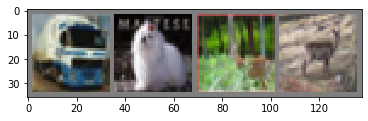

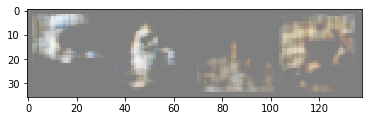

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# ouput images applying autocoder with TRAINING data

dataiter = iter(trainloader)
images, labels = dataiter.next()
with torch.no_grad():
    createdImages = autoEncoder(images.to(device)).to('cpu')
    imshow(torchvision.utils.make_grid(images[0:4]))
    imshow(torchvision.utils.make_grid(createdImages[0:4]))

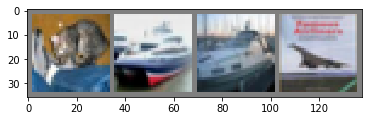

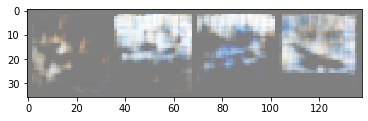

In [116]:
# ouput images applying autocoder with TRAINING data

dataiter = iter(testloader)
images, labels = dataiter.next()
with torch.no_grad():
    createdImages = autoEncoder(images.to(device)).to('cpu')
    imshow(torchvision.utils.make_grid(images[0:4]))
    imshow(torchvision.utils.make_grid(createdImages[0:4]))

In [192]:
# torch.save(autoEncoder.to(device), 'myAutoEncoder.pth')
autoEncoder =  torch.load('myAutoEncoder.pth')

In [193]:
print(autoEncoder)

AutoEncoder(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=120, bias=True)
  (fc6): Linear(in_features=120, out_features=400, bias=True)
  (deconv1): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
)


In [270]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    t = autoEncoder(images, path = 'bottleNeck').to('cpu').numpy()
    print(t.shape)

# extract the 400 demension features in the model with batch_size = 256

(256, 400)


In [274]:
from sklearn.cluster import KMeans
cluster_num = 5
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(t)

In [302]:
print(kmeans.labels_)
#print(kmeans.inertia_)

[4 8 8 4 4 4 0 0 4 1 4 8 4 1 1 4 1 4 3 4 1 9 0 4 4 4 0 8 1 0 0 4 4 1 4 0 4
 8 1 4 4 0 4 0 1 4 4 4 4 4 1 4 4 1 8 4 4 4 4 4 4 4 4 1 4 4 4 4 4 3 4 4 4 4
 8 4 4 4 4 5 8 0 4 8 8 4 4 5 8 4 4 4 8 4 0 4 4 4 6 3 4 4 4 1 4 5 0 0 1 1 4
 4 1 4 4 1 4 3 0 4 8 4 4 4 8 4 4 4 4 4 4 3 1 4 7 4 8 4 4 4 4 4 7 4 1 8 0 1
 1 4 1 1 4 8 0 4 4 8 4 4 4 4 1 4 8 4 8 4 8 8 1 8 4 4 4 8 4 1 4 4 8 8 4 4 8
 4 0 4 6 4 1 4 4 4 4 4 8 8 0 4 1 3 4 4 4 4 4 4 4 4 4 4 7 8 8 2 5 3 9 4 1 4
 4 4 4 4 1 4 7 1 4 3 1 0 8 4 0 3 7 2 4 4 1 8 4 0 4 4 4 0 4 0 1 0 4 4]


size of the 0 th cluster is 157
size of the 1 th cluster is 43
size of the 2 th cluster is 7
size of the 3 th cluster is 4
size of the 4 th cluster is 45


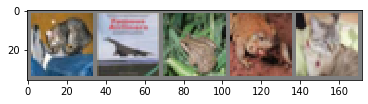

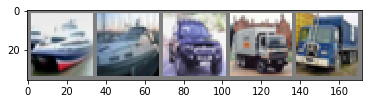

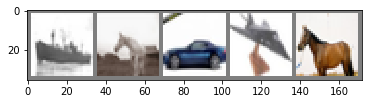

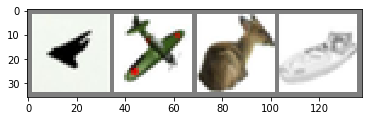

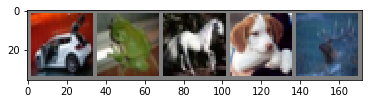

In [280]:
list = [[], [], [], [], []]
for i in range(cluster_num):
    list[i] = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    print(f'size of the %d th cluster is %d' % (i, len(list[i])))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0:5]]))

size of the 0 th cluster is 24
size of the 1 th cluster is 34
size of the 2 th cluster is 2
size of the 3 th cluster is 9
size of the 4 th cluster is 141
size of the 5 th cluster is 4
size of the 6 th cluster is 2
size of the 7 th cluster is 5
size of the 8 th cluster is 33
size of the 9 th cluster is 2


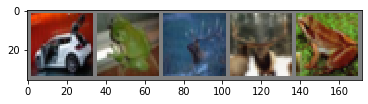

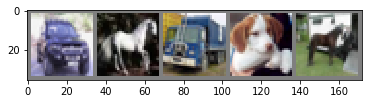

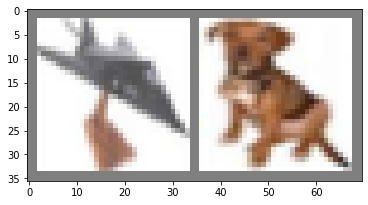

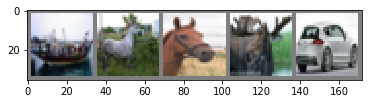

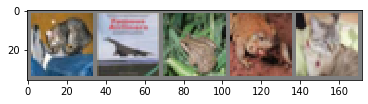

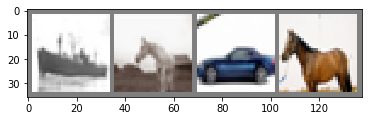

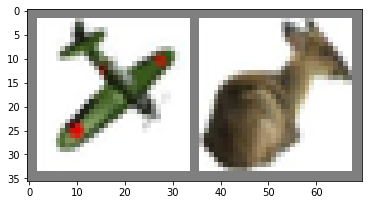

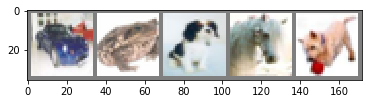

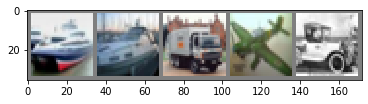

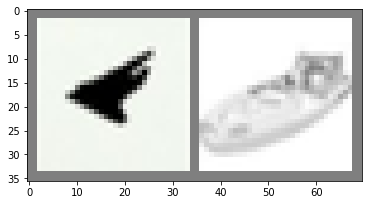

In [293]:
# k = 10 
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(t)

list = []
for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))

33
